<a href="https://colab.research.google.com/github/RoaaM/chest_xray_dataset/blob/main/chest_xray(second_notebook).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#1-get the data from my drive

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAvgPool2D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [ ]:
!unzip '/content/drive/MyDrive/archive.zip'

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'
test_dir = '/content/chest_xray/test'

# 2- Visualize sample of data

In [ ]:
import cv2

# I check several image shape
im = cv2.imread('chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg')

print(im.shape)

(944, 1416, 3)


In [ ]:
sample_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True)

Found 5216 files belonging to 2 classes.


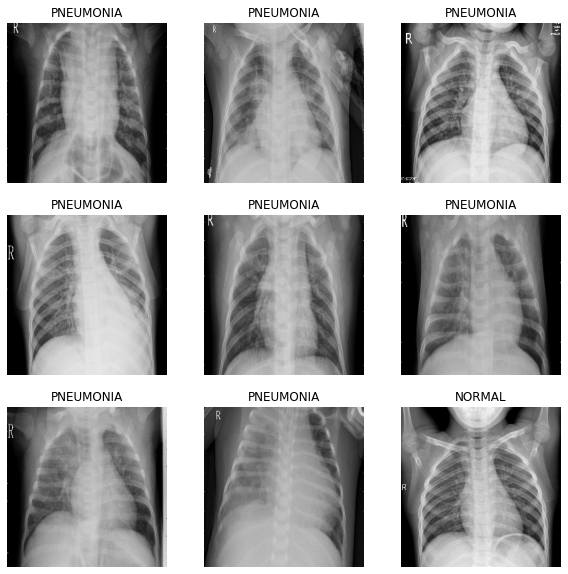

In [ ]:
class_names = sample_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in sample_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#3-pretrained model

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = 224

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=(IMG_SIZE,IMG_SIZE))

validation_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=(IMG_SIZE,IMG_SIZE))

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=False,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=(IMG_SIZE,IMG_SIZE))

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


## VGG-16

In [ ]:
base_model1 = VGG16(include_top = False, weights = "imagenet", input_shape = (224, 224, 3), pooling = "max", classes = 2)

base_model1.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_54 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model_1 = Sequential()
model_1.add(base_model1)
model_1.add(Flatten())

model_1.add(Dense(128, activation = "relu"))
model_1.add(Dense(64, activation = "relu"))
model_1.add(Dense(32, activation = "relu"))
model_1.add(Dense(1, activation = "sigmoid"))

# freeze the layers
for layer in base_model1.layers:
    layer.trainable = False

model_1.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15,
                                                            restore_best_weights = True,
                                                            verbose = 1)


In [ ]:
history = model_1.fit(train_dataset, epochs = 30, validation_data = validation_dataset, steps_per_epoch = 15, callbacks = [early_stopping_callbacks])

Epoch 1/30
15/15 [==============================] - 6s 257ms/step - loss: 1.7295 - accuracy: 0.7229 - val_loss: 0.2003 - val_accuracy: 0.9375
Epoch 2/30
15/15 [==============================] - 3s 197ms/step - loss: 0.4862 - accuracy: 0.8333 - val_loss: 0.1575 - val_accuracy: 0.9375
Epoch 3/30
15/15 [==============================] - 3s 199ms/step - loss: 0.2991 - accuracy: 0.9000 - val_loss: 0.1995 - val_accuracy: 0.9375
Epoch 4/30
15/15 [==============================] - 4s 296ms/step - loss: 0.2506 - accuracy: 0.9042 - val_loss: 0.5611 - val_accuracy: 0.7500
Epoch 5/30
15/15 [==============================] - 3s 223ms/step - loss: 0.1613 - accuracy: 0.9354 - val_loss: 0.2681 - val_accuracy: 0.8125
Epoch 6/30
15/15 [==============================] - 3s 205ms/step - loss: 0.2441 - accuracy: 0.9250 - val_loss: 0.5911 - val_accuracy: 0.8125
Epoch 7/30
15/15 [==============================] - 3s 204ms/step - loss: 0.1994 - accuracy: 0.9271 - val_loss: 0.1674 - val_accuracy: 0.9375
Epoch 

15/15 [==============================] - 3s 168ms/step - loss: 0.1727 - accuracy: 0.9375 - val_loss: 0.1550 - val_accuracy: 0.9375


In [ ]:
model_1.evaluate(test_dataset)

20/20 [==============================] - 4s 197ms/step - loss: 0.4483 - accuracy: 0.8606


[0.44829505681991577, 0.8605769276618958]

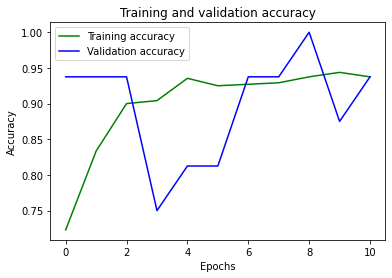

In [ ]:
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
plt.plot(accuracy_train, 'g', label='Training accuracy')
plt.plot(accuracy_val, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


with leaky relu and adam optimizer i get  accuracy 84

with relu and adam optimizer i get  accuracy 86-87

with elu and adam optimizer i get  accuracy 79

with leaky relu and nadam optimizer i get  accuracy 74

with relu and nadam optimizer i get  accuracy 84

with elu and nadam optimizer i get  accuracy 85


```
# i get the best result with vgg model when i use relu as activation function and adam optimizer
```



##ResNet50V2

In [ ]:
base_model2 = tf.keras.applications.ResNet50V2(weights = "imagenet",
                                              input_shape = (224, 224, 3),
                                              pooling = "max", include_top = False,
                                              classes = 2)

for layer in base_model2.layers:
    layer.trainable = False

In [ ]:
model_2 = Sequential()
model_2.add(base_model2)
model_2.add(Flatten())

model_2.add(Dense(128, activation = "LeakyReLU"))
model_2.add(Dense(64, activation = "LeakyReLU"))
model_2.add(Dense(32, activation = "LeakyReLU"))
model_2.add(Dense(1, activation = "sigmoid"))

# freeze the layers
for layer in base_model2.layers:
    layer.trainable = False

model_2.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
history = model_2.fit(train_dataset, epochs = 20, validation_data = validation_dataset, steps_per_epoch = 15,
                              callbacks = [early_stopping_callbacks])

Epoch 1/20
15/15 [==============================] - 9s 301ms/step - loss: 33.5276 - accuracy: 0.6604 - val_loss: 39.3342 - val_accuracy: 0.5000
Epoch 2/20
15/15 [==============================] - 3s 223ms/step - loss: 6.4516 - accuracy: 0.7583 - val_loss: 4.8616 - val_accuracy: 0.7500
Epoch 3/20
15/15 [==============================] - 3s 212ms/step - loss: 3.0507 - accuracy: 0.8667 - val_loss: 21.2566 - val_accuracy: 0.5000
Epoch 4/20
15/15 [==============================] - 3s 230ms/step - loss: 1.6935 - accuracy: 0.9042 - val_loss: 3.6768 - val_accuracy: 0.7500
Epoch 5/20
15/15 [==============================] - 3s 184ms/step - loss: 1.6324 - accuracy: 0.9104 - val_loss: 6.2427 - val_accuracy: 0.7500
Epoch 6/20
15/15 [==============================] - 3s 187ms/step - loss: 1.0696 - accuracy: 0.9083 - val_loss: 5.0649 - val_accuracy: 0.7500
Epoch 7/20
15/15 [==============================] - 3s 182ms/step - loss: 0.5522 - accuracy: 0.9292 - val_loss: 16.1378 - val_accuracy: 0.5000
Ep

15/15 [==============================] - 2s 116ms/step - loss: 1.4030 - accuracy: 0.8846 - val_loss: 1.9229 - val_accuracy: 0.7500


In [ ]:
model_2.evaluate(test_dataset)

20/20 [==============================] - 3s 142ms/step - loss: 2.1149 - accuracy: 0.8349


[2.1149182319641113, 0.8349359035491943]

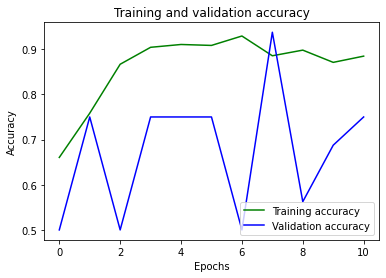

In [ ]:
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
plt.plot(accuracy_train, 'g', label='Training accuracy')
plt.plot(accuracy_val, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


with leaky relu and adam optimizer i get  accuracy 88-89

with relu and adam optimizer i get  accuracy 86

with elu and adam optimizer i get  accuracy 84

with leaky relu and nadam optimizer i get  accuracy 75

with relu and nadam optimizer i get  accuracy 81

with elu and nadam optimizer i get  accuracy 84
```
# i get the best result with resnet model when i use leaky relu as activation function and adam optimizer
```



##MobileNet

In [ ]:
base_model3 = tf.keras.applications.mobilenet_v2.MobileNetV2(weights = "imagenet",
                                                            input_shape = (224, 224, 3),
                                                            include_top = False,
                                                            )

In [ ]:
model_3 = Sequential()
model_3.add(base_model3)
model_3.add(Flatten())

model_3.add(Dense(128, activation = "elu"))
model_3.add(Dense(64, activation = "elu"))
model_3.add(Dense(32, activation = "elu"))
model_3.add(Dense(1, activation = "sigmoid"))

# freeze the layers
for layer in base_model3.layers:
    layer.trainable = False

model_3.compile(optimizer = "nadam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
history = model_3.fit_generator(train_dataset, epochs = 20, validation_data = validation_dataset, steps_per_epoch = 15,
                              callbacks = [early_stopping_callbacks])

Epoch 1/20


<ipython-input-159-780cfef3b4fa>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_3.fit_generator(train_dataset, epochs = 20, validation_data = validation_dataset, steps_per_epoch = 15,


15/15 [==============================] - 8s 257ms/step - loss: 3.1574 - accuracy: 0.7188 - val_loss: 2.3978 - val_accuracy: 0.7500
Epoch 2/20
15/15 [==============================] - 3s 205ms/step - loss: 0.2335 - accuracy: 0.9146 - val_loss: 1.0404 - val_accuracy: 0.6250
Epoch 3/20
15/15 [==============================] - 3s 176ms/step - loss: 0.7286 - accuracy: 0.8375 - val_loss: 2.0929 - val_accuracy: 0.7500
Epoch 4/20
15/15 [==============================] - 3s 192ms/step - loss: 0.1961 - accuracy: 0.9458 - val_loss: 1.9054 - val_accuracy: 0.6875
Epoch 5/20
15/15 [==============================] - 3s 185ms/step - loss: 0.2556 - accuracy: 0.9292 - val_loss: 1.0119 - val_accuracy: 0.6875
Epoch 6/20
15/15 [==============================] - 3s 187ms/step - loss: 0.1864 - accuracy: 0.9271 - val_loss: 0.6783 - val_accuracy: 0.8125
Epoch 7/20
15/15 [==============================] - 2s 171ms/step - loss: 0.1378 - accuracy: 0.9542 - val_loss: 0.8400 - val_accuracy: 0.7500
Epoch 8/20
15/15 

15/15 [==============================] - 1s 89ms/step - loss: 0.1978 - accuracy: 0.9303 - val_loss: 0.5775 - val_accuracy: 0.8125


In [ ]:
model_3.evaluate(test_dataset)

20/20 [==============================] - 3s 131ms/step - loss: 0.3974 - accuracy: 0.8446


[0.3974058926105499, 0.8445512652397156]

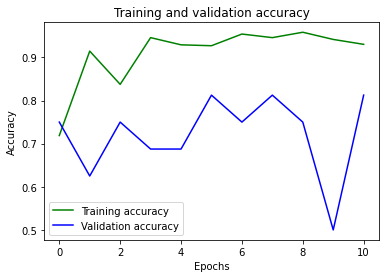

In [ ]:
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
plt.plot(accuracy_train, 'g', label='Training accuracy')
plt.plot(accuracy_val, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


with leaky relu and adam optimizer i get  accuracy 79

with relu and adam optimizer i get  accuracy 69

with elu and adam optimizer i get  accuracy 76

with leaky relu and nadam optimizer i get  accuracy 84-85

with relu and nadam optimizer i get  accuracy 80

with elu and nadam optimizer i get  accuracy 83-84

```
# i get the best result with mobilenet model when i use elu or leaky relu as activation function and nadam optimizer
```

